In [1]:
import argparse
import sys
import re
from typing import Dict

import torch
from datasets import Audio, Dataset, load_dataset, load_metric

from pyctcdecode import BeamSearchDecoderCTC
from transformers import AutoFeatureExtractor, AutoTokenizer, pipeline
import transformers
import librosa

c:\Users\Krist\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import json

# Opening JSON file
dutch = open('additionalInfo.json',)
flemish= open('additionalInfo2.json',)
# returns JSON object as 
# a dictionary
prediction = json.load(dutch)
prediction2 = json.load(flemish)

df1 = pd.DataFrame(prediction)
#df1.to_csv("Nederlands.csv", index= False)

df2 = pd.DataFrame(prediction2)
#df2.to_csv("Flaams.csv", index= False)

df2

,word,lm_score,ngram_size,oov,silence_within,missed_speech_before,logits_median,start_time,end_time
0,gefeliciteerd,-3.445053,2,False,-0.083076,-0.209878,-2.049756,22.74,23.80
1,u,-2.294330,3,False,NaN,NaN,-1.982012,24.60,24.62
2,mag,-2.686302,4,False,-0.354820,-0.154417,-2.508331,24.78,24.94
3,vandaag,-3.870203,3,False,-0.284183,-0.144426,-2.391098,25.08,25.56
4,een,-2.103334,3,False,NaN,-0.115802,-2.320269,25.66,25.78
...,...,...,...,...,...,...,...,...,...
579,gemaakt,-1.354666,4,False,-0.150180,-0.164887,-2.636353,558.94,559.36
580,bedankt,-4.973330,2,False,-0.046790,-0.202904,-2.647401,562.06,562.48
581,voor,-1.255184,3,False,NaN,-0.146904,-1.909894,562.66,562.78
582,het,-0.508714,4,False,-0.323351,-0.134846,-2.524254,562.92,563.08


In [3]:
# goede tijden, slechte tijden
# [] goede                -2.432432    1
# [goede] tijden          -1.3213      2 
# [goede, tijden] slechte -0.5213      3
# [iskaj de some some] bakker          5

non-native dutch:  count    582.000000
mean      -3.152609
std        1.910573
min      -10.279678
25%       -3.754827
50%       -2.794437
75%       -1.915589
max       -0.024317
Name: lm_score, dtype: float64
med: -2.7944365739822388
flemish: count    584.000000
mean      -2.720112
std        1.663927
min       -9.518995
25%       -3.481771
50%       -2.474140
75%       -1.627759
max       -0.007368
Name: lm_score, dtype: float64
med: -2.4741400480270386


<AxesSubplot:ylabel='lm_score'>

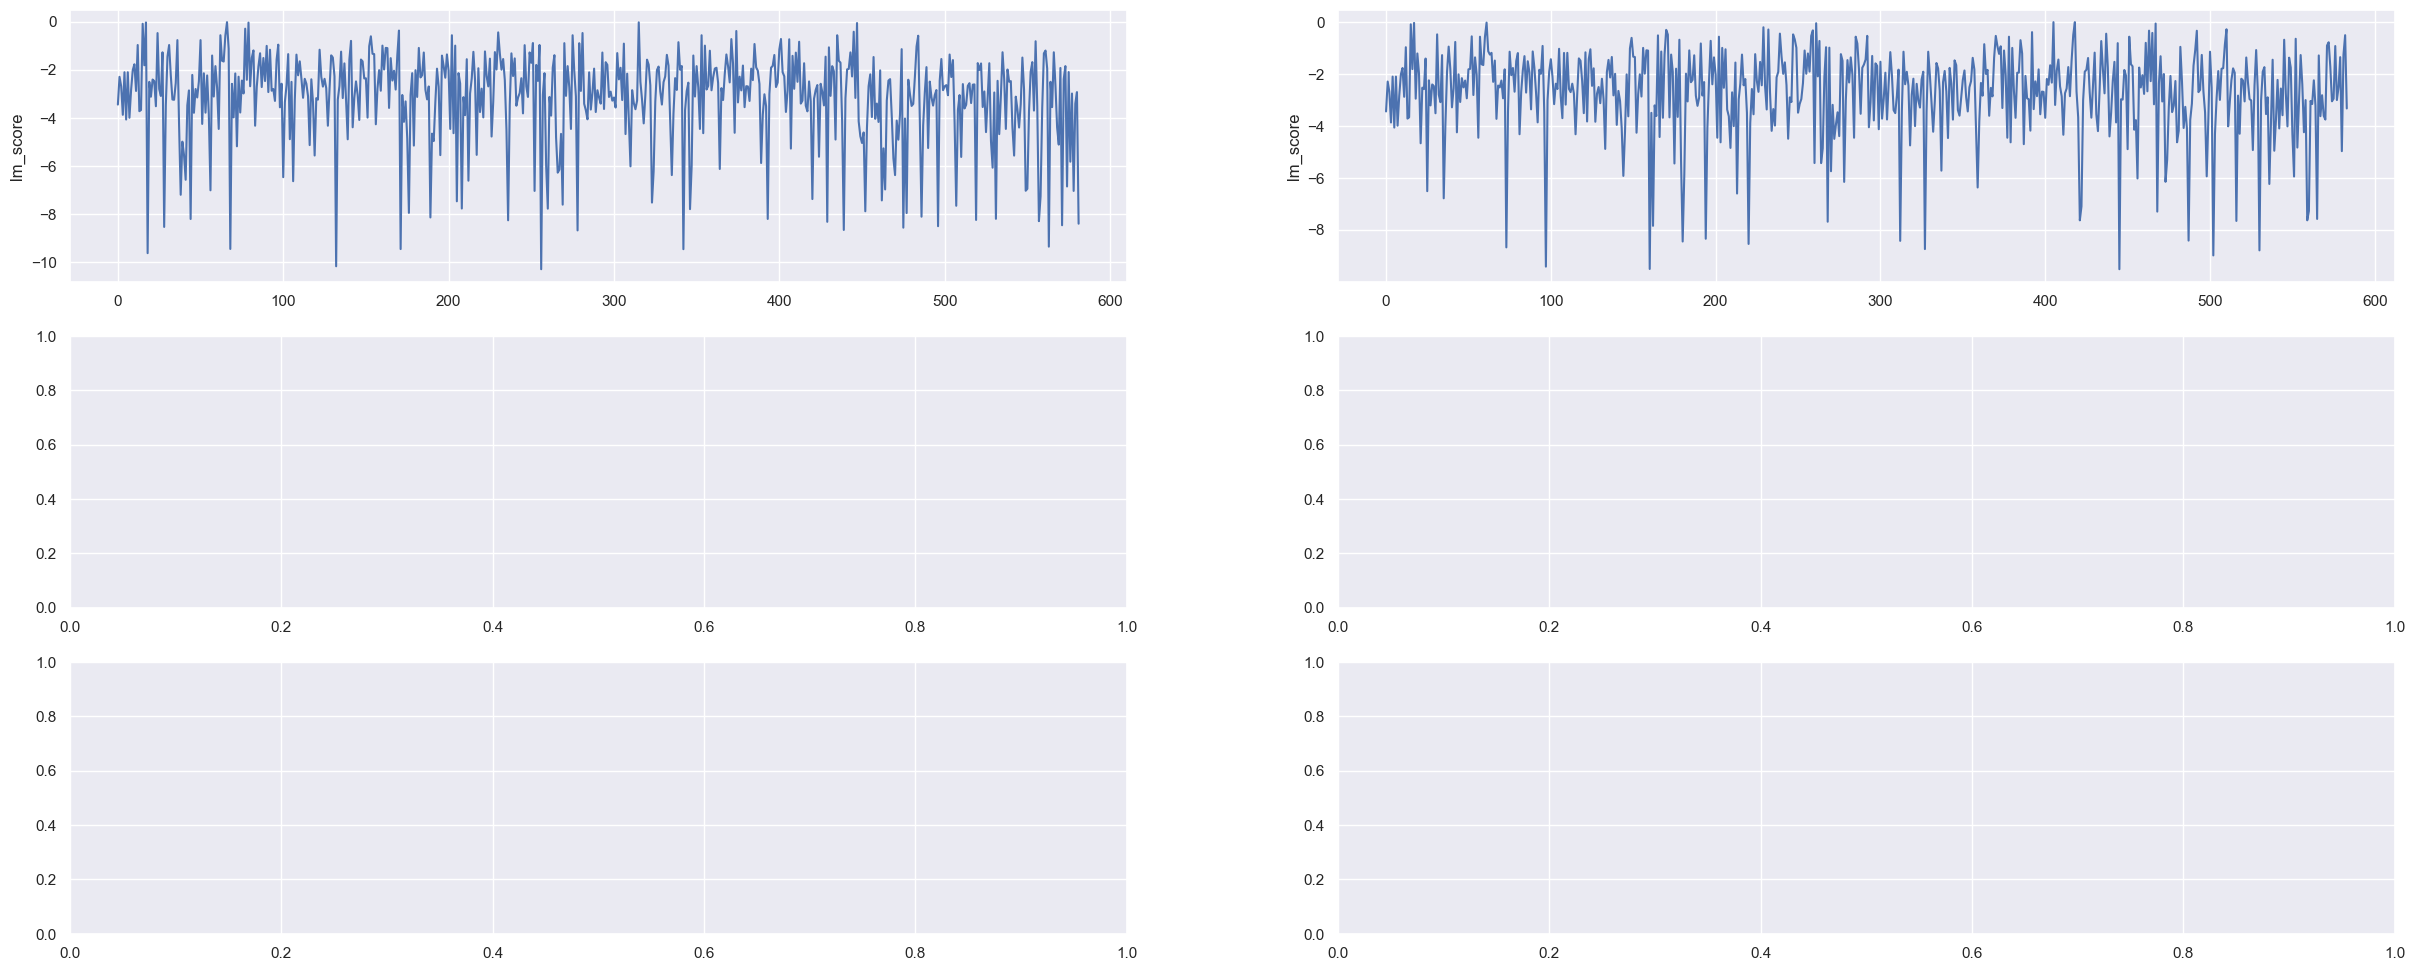

In [10]:
import statistics
print('non-native dutch: ',df1['lm_score'].describe())
print('med:',statistics.median(df1['lm_score']))
print('flemish:', df2['lm_score'].describe())
print('med:',statistics.median(df2['lm_score']))

#  median good for outliers

fig, ax = plt.subplots(figsize=(30, 12), ncols=2, nrows=3)
sns.set_theme()
sns.lineplot(data=df1, y='lm_score', x=df1.index, ax=ax[0, 0])
sns.lineplot(data=df2, y='lm_score', x=df2.index, ax=ax[0, 1])

# sns.lineplot(data=df1, y='ngram_size', x=df1.index, ax=ax[0, 1])
# sns.lineplot(data=df1, y='oov', x=df1.index, ax=ax[1, 0])
# sns.lineplot(data=df1, y='silence_within', x=df1.index, ax=ax[1, 1])
# sns.lineplot(data=df1, y='missed_speech_before', x=df1.index, ax=ax[2, 0])
# sns.lineplot(data=df1, y='logits_median', x=df1.index, ax=ax[2, 1])

## Base information parameters
<b>lm_score:</b> log10 probability of the model generating this sentence

<b>ngram_size:</b> from which ngram size has the word been generated 

oov: when the prediction is not in the language model


## Fancy information parameters
Following three are novelty function-based (that says something about the similarity to frames around it)

<b>silence within:</b> do a rolling min on the novelty function, if the max of that is above/below (?) a certain value it is likely that there is a silence within

<b>missed_speech_before:</b> the mean value of the novelty function between words, if this is above/below (?) a certain value it is likely that there is a word missed in that period

<b>logits_median:</b> get the median value of all the logit values in the word, if these are below a certain value it is likely that the speech was unintelligible

In [ ]:
first_prediction = prediction[0]
first_prediction

In [ ]:
# lm_score
print(10 ** first_prediction['lm_score'])

In [ ]:
sound_array, sr = librosa.load("/dbfs/mnt/ds-data-apps/iskaj/test_videos/rtl_paddestoel.wav", sr = sampling_rate)
print(f"Duration is {len(sound_array)/sr} seconds")

In [ ]:
prediction = asr(sound_array, chunk_length_s = 10, stride_length_s = 2)
print(" ".join(row['word'] for row in prediction))

fig, ax = plt.subplots(figsize=(30, 12), ncols=2, nrows=3)
sns.set_theme()

sns.lineplot(data=df, y='lm_score', x=df.index, ax=ax[0, 0])
sns.lineplot(data=df, y='ngram_size', x=df.index, ax=ax[0, 1])
sns.lineplot(data=df, y='oov', x=df.index, ax=ax[1, 0])
sns.lineplot(data=df, y='silence_within', x=df.index, ax=ax[1, 1])
sns.lineplot(data=df, y='missed_speech_before', x=df.index, ax=ax[2, 0])
sns.lineplot(data=df, y='logits_median', x=df.index, ax=ax[2, 1])

In [ ]:
sound_array, sr = librosa.load("/dbfs/mnt/ds-data-apps/iskaj/test_videos/wapenhandel.wav", sr = sampling_rate, duration=120)
print(f"Duration is {len(sound_array)/sr} seconds")

In [ ]:
prediction = asr(sound_array, chunk_length_s = 10, stride_length_s = 2)
print(" ".join(row['word'] for row in prediction))

fig, ax = plt.subplots(figsize=(30, 12), ncols=2, nrows=3)
sns.set_theme()

x = df['start_time']
sns.lineplot(data=df, y='lm_score', x=x, ax=ax[0, 0])
sns.lineplot(data=df, y='ngram_size', x=x, ax=ax[0, 1])
sns.lineplot(data=df, y='oov', x=x, ax=ax[1, 0])
sns.lineplot(data=df, y='silence_within', x=x, ax=ax[1, 1])
sns.lineplot(data=df, y='missed_speech_before', x=x, ax=ax[2, 0])
sns.lineplot(data=df, y='logits_median', x=x, ax=ax[2, 1])

In [ ]:
sound_array, sr = librosa.load("/dbfs/mnt/ds-data-apps/iskaj/test_videos/jinek_hour.wav", sr = sampling_rate, duration=600)
print(f"Duration is {len(sound_array)/sr} seconds")

In [ ]:
prediction = asr(sound_array, chunk_length_s = 10, stride_length_s = 2)
print(" ".join(row['word'] for row in prediction))

fig, ax = plt.subplots(figsize=(30, 12), ncols=2, nrows=3)
sns.set_theme()

x = df['start_time']
sns.lineplot(data=df, y='lm_score', x=x, ax=ax[0, 0])
sns.lineplot(data=df, y='ngram_size', x=x, ax=ax[0, 1])
sns.lineplot(data=df, y='oov', x=x, ax=ax[1, 0])
sns.lineplot(data=df, y='silence_within', x=x, ax=ax[1, 1])
sns.lineplot(data=df, y='missed_speech_before', x=x, ax=ax[2, 0])
sns.lineplot(data=df, y='logits_median', x=x, ax=ax[2, 1])

## Useful links:
Pipelines documentation: https://github.com/huggingface/transformers/blob/main/src/transformers/pipelines/automatic_speech_recognition.py